In [1]:

# import the required libraries:
import sentencepiece as spm
import pandas as pd
from keras.utils import pad_sequences
import torch
import torch.nn as nn
import numpy as np
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.optim import Adam
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from config import create_session, Cases, VLW

2024-06-19 18:42:10.992719: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Intializing the new tokenizer + model class

In [2]:
#Execute this script to set values for different parameters:
BATCH_SIZE = 40
LEARNING_RATE = 0.001
EPOCHS = 20
LSTM_NODES = 256
NUM_SENTENCES = 40
SENTENCE_LENGTH = 98
VOCAB_SIZE = 10000
# 4096 is the dimension returned from the tok_embeddings.weight key of the pretrained aix model
EMBEDDING_SIZE = 4096
NUM_EPOCHS = 20

### Preparation for Thorny Flat Cluster Access

1. Pytorch model loading/saving.
2. Jupyter commands for distributing work across multiple clusters. 
3. 

In [3]:
sp = spm.SentencePieceProcessor()
sp.Load('tokenizer.model')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cuda_available = torch.cuda.is_available()
print("CUDA Available:", cuda_available)

CUDA Available: False


Get the target sequences ready to be passed into the model features will be the tokenized sequences, labels will be the binary classification of which set of tokens represents the bad sequence. 


In [4]:
session = create_session()

# Query the database and get a list of Cases objects for each CWE
records = session.query(VLW).all()

data = [record.vlw_content for record in records]
labels  = [record.vulnerability_location  for record in records]

# Split the data into train and test sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
# Encode sentences 
train_sequences = [[sp.EncodeAsIds(line) for line in text.split('\n')[:40]] for text in train_data]
test_sequences = [[sp.EncodeAsIds(line) for line in text.split('\n')[:40]] for text in test_data]


# This version could be useful if I want to avoid the padding issue later on. 
# train_sequences = [[sp.EncodeAsIds(line) for line in text.split('\n')[:40]] for text in train_data if len(text.split('\n')) >= 40]
# test_sequences = [[sp.EncodeAsIds(line) for line in text.split('\n')[:40]] for text in test_data if len(text.split('\n')) >= 40]

# # Print the number of train and test sequences
# print(f"Number of train sequences: {len(train_sequences)}")
# print(f"Number of test sequences: {len(test_sequences)}")


# Finding the longest indivudial tokenized sentences
max_length_train = max(max(len(seq) for seq in text) for text in train_sequences)
max_length_test = max(max(len(seq) for seq in text) for text in test_sequences)

# Get the maximum length across both sets
max_length = max(max_length_train, max_length_test)

# Convert labels to one-hot vectors

num_classes = 40  
train_labels = torch.stack([torch.nn.functional.one_hot(torch.tensor(label), num_classes=num_classes) for label in train_labels])
test_labels = torch.stack([torch.nn.functional.one_hot(torch.tensor(label), num_classes=num_classes) for label in test_labels])

print('max_length:', max_length)
print('Train Labels:', train_labels[0])
print('Test Labels:', test_labels[0])



max_length: 98
Train Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
Test Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])


Padding + Data Loading


In [5]:
# Pad each individual sequence to a length of 98
train_sequences_padded = [pad_sequences(text, maxlen=98, padding='post') for text in train_sequences]
test_sequences_padded = [pad_sequences(text, maxlen=98, padding='post') for text in test_sequences]

print('Train sequences shape:', train_sequences_padded[0].shape)
print('Test sequences shape:', test_sequences_padded[0].shape)

Train sequences shape: (40, 98)
Test sequences shape: (40, 98)


Debugging the shape here there is a 39 dimension tensor throwing things off

In [6]:
# Create a list of indices where the sequence length is not 40
drop_indices = [i for i, seq in enumerate(train_sequences_padded) if len(seq) != 40]

# Drop these indices from train_sequences_padded and train_labels
train_sequences_padded = [seq for i, seq in enumerate(train_sequences_padded) if i not in drop_indices]
train_labels = [label for i, label in enumerate(train_labels) if i not in drop_indices]

# Print the number of remaining sequences and labels
print(f"Number of remaining train sequences: {len(train_sequences_padded)}")
print(f"Number of remaining train labels: {len(train_labels)}")



Number of remaining train sequences: 43369
Number of remaining train labels: 43369


Just going to cull the few thousand or so that had an inoccrect length, still testing about 40k windows it looks like. Reapeating the same for testing group. 

In [7]:
# Create a list of indices where the sequence length is not 40
drop_indices_test = [i for i, seq in enumerate(test_sequences_padded) if len(seq) != 40]

# Drop these indices from test_sequences_padded and test_labels
test_sequences_padded = [seq for i, seq in enumerate(test_sequences_padded) if i not in drop_indices_test]
test_labels = [label for i, label in enumerate(test_labels) if i not in drop_indices_test]

# Print the number of remaining sequences and labels
print(f"Number of remaining test sequences: {len(test_sequences_padded)}")
print(f"Number of remaining test labels: {len(test_labels)}")

Number of remaining test sequences: 10816
Number of remaining test labels: 10816


I previously incorrectly thought this is our batch size for this model run aka window size. (context length),  but batch size needs to rpresent the 43k size we have of segments, not the window size. 

our final dimensions are 43369 X 40 X 98?? 
Not sure which dataloader or batch takes which dimensions

In [8]:
train_sequences_tensor = torch.tensor(train_sequences_padded)
# Assuming train_labels needs to be stacked for a specific reason
train_labels = torch.stack(train_labels)  # Keep this if it's necessary for your model
train_dataset = TensorDataset(train_sequences_tensor, train_labels)

# Create a DataLoader with a specific batch size and drop_last option
batch_size = 40
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Print the shape of the first batch
first_batch = next(iter(train_loader))
print('First train batch shape:', first_batch[0].shape)

First train batch shape: torch.Size([40, 40, 98])


/tmp/ipykernel_19958/1395410304.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1702400268359/work/torch/csrc/utils/tensor_new.cpp:261.)
  train_sequences_tensor = torch.tensor(train_sequences_padded)


Next creating the data loader for the test labels too.

In [9]:
test_sequences_tensor = torch.tensor(test_sequences_padded)
test_labels = torch.stack(test_labels)
test_dataset = TensorDataset(test_sequences_tensor, test_labels)
batch_size = 40

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

first_batch = next(iter(test_loader))
print('First test batch shape:', first_batch[0].shape)

First test batch shape: torch.Size([40, 40, 98])


In [10]:
print('train_sequences_tensor shape:', train_sequences_tensor.shape)
print('train_sequences_tensor dtype:', train_sequences_tensor.dtype)
print('train_labels_tensor shape:', train_labels.shape)
print('train_labels_tensor dtype:', train_labels.dtype)

train_sequences_tensor shape: torch.Size([43369, 40, 98])
train_sequences_tensor dtype: torch.int32
train_labels_tensor shape: torch.Size([43369, 40])
train_labels_tensor dtype: torch.int64


In [11]:
try:
    pretrained_weights = torch.load('aix3-7b-base-1.pt')
    print("Weights loaded successfully.")
except Exception as e:
    print(f"Failed to load weights: {e}")

# Print all keys in the state dictionary
print(pretrained_weights.keys())

# Once you've identified the key for the embeddings, you can extract them like this:
word_vectors = pretrained_weights['tok_embeddings.weight']
print(word_vectors.shape)

Weights loaded successfully.
dict_keys(['tok_embeddings.weight', 'output.weight', 'norm.weight', 'layers.0.attention.query_key_value.weight', 'layers.0.feed_forward.w1.weight', 'layers.0.feed_forward.w3.weight', 'layers.0.attention.wo.weight', 'layers.0.feed_forward.w2.weight', 'layers.0.attention_norm.weight', 'layers.0.ffn_norm.weight', 'layers.1.attention.query_key_value.weight', 'layers.1.feed_forward.w1.weight', 'layers.1.feed_forward.w3.weight', 'layers.1.attention.wo.weight', 'layers.1.feed_forward.w2.weight', 'layers.1.attention_norm.weight', 'layers.1.ffn_norm.weight', 'layers.2.attention.query_key_value.weight', 'layers.2.feed_forward.w1.weight', 'layers.2.feed_forward.w3.weight', 'layers.2.attention.wo.weight', 'layers.2.feed_forward.w2.weight', 'layers.2.attention_norm.weight', 'layers.2.ffn_norm.weight', 'layers.3.attention.query_key_value.weight', 'layers.3.feed_forward.w1.weight', 'layers.3.feed_forward.w3.weight', 'layers.3.attention.wo.weight', 'layers.3.feed_forward.w

In [12]:

torch.manual_seed(691)

# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, batch_first, bidirectional, dropout, pretrained_weights, batch_size, sentence_length):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, bidirectional=bidirectional, dropout=dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.embedding.weight.data.copy_(pretrained_weights)

    def forward(self, text):
        batch_size, sentence_length, num_sentences = text.size()
        text = text.view(batch_size, sentence_length * num_sentences)
        # embedded = self.dropout(self.embedding(text.view(-1, sentence_length)))
        # embedded = embedded.view(batch_size, num_sentences, sentence_length, -1)
        embedded = self.dropout(self.embedding(text))
        #print(f"Shape after embedding: {embedded.shape}")
        
        lstm_output, (hidden, _) = self.rnn(embedded)
        # print(f"Shape after LSTM: {lstm_output.shape}")
    
        pooled = torch.mean(lstm_output, dim=1)
        # print(f"Shape after pooled: {pooled.shape}")
        # Pass through the fully connected layer
        output = self.fc(self.dropout(pooled))
        # This would only be if using BCELoss 
        output = torch.sigmoid(output)
        # print(f"Shape of final output: {output.shape}")
        
        
        return output

In [13]:
torch.manual_seed(691)

# Initialize the model
model = LSTMClassifier(
    vocab_size=49152,
    embedding_dim=EMBEDDING_SIZE,  
    hidden_dim=LSTM_NODES,
    output_dim=40,  # Changed from 2 to 40 to match your label dimensions
    n_layers=2,
    batch_first=True,
    bidirectional=True,
    dropout=0.5,
    pretrained_weights=word_vectors,
    batch_size = BATCH_SIZE,
    sentence_length = SENTENCE_LENGTH
)
print(model)

model.eval()

# Disable gradient calculations
with torch.no_grad():
    # Get the first batch of data from the training loader
    batch_sequences, batch_labels = next(iter(train_loader))
        
    # Pass the batch of sequences through the model
    outputs = model(batch_sequences)

    #print(outputs.shape)

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    model.train()
    
    for batch_sequences, batch_labels in tqdm(iterator, desc='Training'):  # Wrap iterator with tqdm
            optimizer.zero_grad()
            predictions = model(batch_sequences)
            
            predictions = predictions.view(-1, 40).float()  # Flatten if necessary
            batch_labels = batch_labels.view(-1, 40).float()  # Ensure labels are correctly shaped
            
            loss = criterion(predictions, batch_labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
    
    return epoch_loss / len(iterator)
    

def evaluate(model, iterator, criterion):
    epoch_loss = 0
    model.eval()
    all_probabilities = []  # Initialize list to store probabilities
    all_labels = []

    with torch.no_grad():
        for batch_sequences, batch_labels in tqdm(iterator, desc='Evaluation'):  # Wrap iterator with tqdm
            predictions = model(batch_sequences)
            predictions = predictions.view(-1, 40).float()  # Flatten if necessary
            batch_labels = batch_labels.view(-1, 40).float()  # Ensure labels are correctly shaped
            
            # Convert logits to probabilities for plotting
            probabilities = torch.sigmoid(predictions)
            all_probabilities.extend(probabilities.cpu().detach().numpy())
            all_labels.extend(batch_labels.cpu().detach().numpy())
            
            loss = criterion(predictions, batch_labels)
            epoch_loss += loss.item()
    
    return epoch_loss / len(iterator), all_probabilities, all_labels

LSTMClassifier(
  (embedding): Embedding(49152, 4096)
  (rnn): LSTM(4096, 256, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=40, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


 The output shape [64, 2] is what we expect for a sequence classification task. This means that for each sequence in the batch (64 in total), the model is outputting a 2-dimensional vector. These vectors can be interpreted as the probabilities of each sequence belonging to each of the two classes (good or bad).

Training:   0%|          | 0/1084 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Epoch: 1, Train Loss: 0.109, Val. Loss: 0.104


Training:   0%|          | 0/1084 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Epoch: 2, Train Loss: 0.106, Val. Loss: 0.104


Training:   0%|          | 0/1084 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Epoch: 3, Train Loss: 0.105, Val. Loss: 0.104


Training:   0%|          | 0/1084 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Epoch: 4, Train Loss: 0.105, Val. Loss: 0.103


Training:   0%|          | 0/1084 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Epoch: 5, Train Loss: 0.101, Val. Loss: 0.096


Training:   0%|          | 0/1084 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Epoch: 6, Train Loss: 0.096, Val. Loss: 0.093


Training:   0%|          | 0/1084 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Epoch: 7, Train Loss: 0.093, Val. Loss: 0.091


Training:   0%|          | 0/1084 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Epoch: 8, Train Loss: 0.091, Val. Loss: 0.090


Training:   0%|          | 0/1084 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Epoch: 9, Train Loss: 0.090, Val. Loss: 0.088


Training:   0%|          | 0/1084 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/270 [00:00<?, ?it/s]

Epoch: 10, Train Loss: 0.089, Val. Loss: 0.087


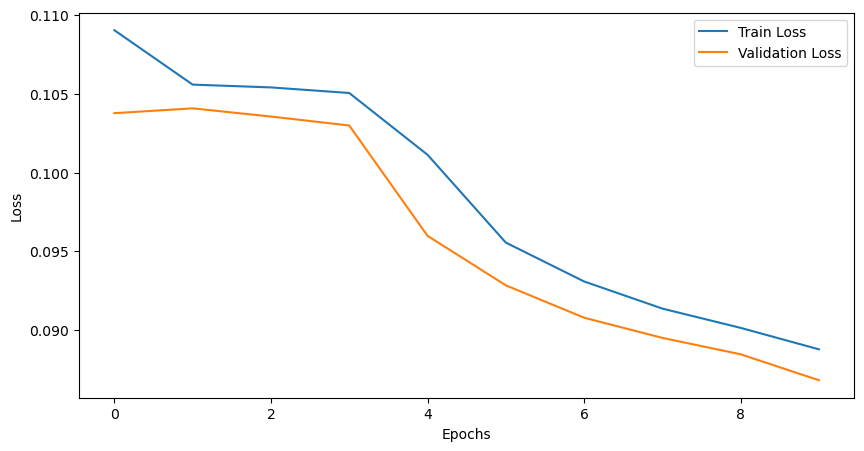

Training:   0%|          | 0/1084 [00:00<?, ?it/s]

In [14]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCELoss()

# Define the number of epochs
N_EPOCHS = 10

# Store the loss values for plotting
train_losses = []
valid_losses = []

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion)
    valid_loss, predictions, labels = evaluate(model, test_loader, criterion)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.3f}, Val. Loss: {valid_loss:.3f}')

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

train_loss, _, _ = train(model, train_loader, optimizer, criterion)
valid_loss, predictions, labels = evaluate(model, test_loader, criterion)

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(labels, predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCELoss()

# Define the number of epochs
N_EPOCHS = 10

# Store the loss values for plotting
train_losses = []
valid_losses = []

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_loader, optimizer, criterion)
    valid_loss, predictions, labels = evaluate(model, test_loader, criterion)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.3f}, Val. Loss: {valid_loss:.3f}')

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

train_loss, _, _ = train(model, train_loader, optimizer, criterion)
valid_loss, predictions, labels = evaluate(model, test_loader, criterion)

# Calculate the ROC curve
fpr, tpr, _ = roc_curve(labels, predictions)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
unique_labels = torch.unique(batch_labels)
print(unique_labels)